# AnoGAN
- 2020.08.11 : Genrator 학습 수 ... 4

# 개발일지
- 2020.08.14 : 분율 추출 구현
- 2020.08.15 : 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티티늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100 # z벡터의 잠재공간(latent space)의 크기
workers = 4 # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
data_root = "../../../OhSeHyeon/source/dataset/aug_train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 920
device : cuda:0


# MODEL

In [4]:
# Generative Adversarial Networks Model

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1 , 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature

# Loss & Optim

In [5]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train(epoch, learning_G_per_D):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train Discriminator
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss 
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train Generater
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification, _ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x) : %.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(G.state_dict(), 'G.ckpt')
#torch.save(D.state_dict(), 'D.ckpt')

In [7]:
for epoch in range(epochs):
    train(epoch, learning_G_per_D = 1)

/home/piai/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/14]
- D_loss : 1.3873 / G_loss : 0.6926
- D(x) : 0.5002 / D(G(z1)) : 0.5007 / D(G(z2)) : 0.5003
[1/100][1/14]
- D_loss : 1.3852 / G_loss : 0.6932
- D(x) : 0.5010 / D(G(z1)) : 0.5004 / D(G(z2)) : 0.5000
[1/100][2/14]
- D_loss : 1.3837 / G_loss : 0.6936
- D(x) : 0.5015 / D(G(z1)) : 0.5002 / D(G(z2)) : 0.4998
[1/100][3/14]
- D_loss : 1.3841 / G_loss : 0.6921
- D(x) : 0.5021 / D(G(z1)) : 0.5009 / D(G(z2)) : 0.5005
[1/100][4/14]
- D_loss : 1.3818 / G_loss : 0.6933
- D(x) : 0.5026 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.4999
[1/100][5/14]
- D_loss : 1.3789 / G_loss : 0.6940
- D(x) : 0.5037 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.4996
[1/100][6/14]
- D_loss : 1.3838 / G_loss : 0.6930
- D(x) : 0.5018 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5001
[1/100][7/14]
- D_loss : 1.3782 / G_loss : 0.6941
- D(x) : 0.5040 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.4996
[1/100][8/14]
- D_loss : 1.3775 / G_loss : 0.6937
- D(x) : 0.5046 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.4997
[1/100][9/14]
- D_loss : 1.3779 / G_loss : 0.6

[6/100][10/14]
- D_loss : 1.2354 / G_loss : 0.7394
- D(x) : 0.5583 / D(G(z1)) : 0.4789 / D(G(z2)) : 0.4774
[6/100][11/14]
- D_loss : 1.2356 / G_loss : 0.7411
- D(x) : 0.5573 / D(G(z1)) : 0.4781 / D(G(z2)) : 0.4766
[6/100][12/14]
- D_loss : 1.2392 / G_loss : 0.7424
- D(x) : 0.5548 / D(G(z1)) : 0.4776 / D(G(z2)) : 0.4760
[6/100][13/14]
- D_loss : 1.2262 / G_loss : 0.7462
- D(x) : 0.5603 / D(G(z1)) : 0.4758 / D(G(z2)) : 0.4742
[7/100][0/14]
- D_loss : 1.2243 / G_loss : 0.7477
- D(x) : 0.5605 / D(G(z1)) : 0.4751 / D(G(z2)) : 0.4735
[7/100][1/14]
- D_loss : 1.2256 / G_loss : 0.7501
- D(x) : 0.5585 / D(G(z1)) : 0.4740 / D(G(z2)) : 0.4723
[7/100][2/14]
- D_loss : 1.2127 / G_loss : 0.7523
- D(x) : 0.5647 / D(G(z1)) : 0.4730 / D(G(z2)) : 0.4713
[7/100][3/14]
- D_loss : 1.2025 / G_loss : 0.7544
- D(x) : 0.5696 / D(G(z1)) : 0.4721 / D(G(z2)) : 0.4703
[7/100][4/14]
- D_loss : 1.2073 / G_loss : 0.7576
- D(x) : 0.5653 / D(G(z1)) : 0.4707 / D(G(z2)) : 0.4688
[7/100][5/14]
- D_loss : 1.2054 / G_loss :

[12/100][4/14]
- D_loss : 0.8609 / G_loss : 1.0691
- D(x) : 0.6462 / D(G(z1)) : 0.3452 / D(G(z2)) : 0.3433
[12/100][5/14]
- D_loss : 0.8514 / G_loss : 1.0737
- D(x) : 0.6511 / D(G(z1)) : 0.3437 / D(G(z2)) : 0.3418
[12/100][6/14]
- D_loss : 0.8490 / G_loss : 1.0776
- D(x) : 0.6511 / D(G(z1)) : 0.3423 / D(G(z2)) : 0.3404
[12/100][7/14]
- D_loss : 0.8332 / G_loss : 1.0815
- D(x) : 0.6602 / D(G(z1)) : 0.3410 / D(G(z2)) : 0.3391
[12/100][8/14]
- D_loss : 0.8361 / G_loss : 1.0861
- D(x) : 0.6566 / D(G(z1)) : 0.3394 / D(G(z2)) : 0.3375
[12/100][9/14]
- D_loss : 0.8300 / G_loss : 1.0909
- D(x) : 0.6593 / D(G(z1)) : 0.3378 / D(G(z2)) : 0.3359
[12/100][10/14]
- D_loss : 0.8291 / G_loss : 1.0954
- D(x) : 0.6583 / D(G(z1)) : 0.3363 / D(G(z2)) : 0.3344
[12/100][11/14]
- D_loss : 0.8210 / G_loss : 1.1003
- D(x) : 0.6619 / D(G(z1)) : 0.3346 / D(G(z2)) : 0.3328
[12/100][12/14]
- D_loss : 0.8465 / G_loss : 1.1046
- D(x) : 0.6438 / D(G(z1)) : 0.3331 / D(G(z2)) : 0.3313
[12/100][13/14]
- D_loss : 0.8127 

[17/100][12/14]
- D_loss : 0.6031 / G_loss : 1.3661
- D(x) : 0.7358 / D(G(z1)) : 0.2562 / D(G(z2)) : 0.2551
[17/100][13/14]
- D_loss : 0.6008 / G_loss : 1.3695
- D(x) : 0.7367 / D(G(z1)) : 0.2553 / D(G(z2)) : 0.2542
[18/100][0/14]
- D_loss : 0.6090 / G_loss : 1.3720
- D(x) : 0.7301 / D(G(z1)) : 0.2547 / D(G(z2)) : 0.2536
[18/100][1/14]
- D_loss : 0.5962 / G_loss : 1.3753
- D(x) : 0.7386 / D(G(z1)) : 0.2538 / D(G(z2)) : 0.2528
[18/100][2/14]
- D_loss : 0.5853 / G_loss : 1.3788
- D(x) : 0.7457 / D(G(z1)) : 0.2530 / D(G(z2)) : 0.2519
[18/100][3/14]
- D_loss : 0.5917 / G_loss : 1.3823
- D(x) : 0.7402 / D(G(z1)) : 0.2521 / D(G(z2)) : 0.2510
[18/100][4/14]
- D_loss : 0.5923 / G_loss : 1.3848
- D(x) : 0.7391 / D(G(z1)) : 0.2514 / D(G(z2)) : 0.2504
[18/100][5/14]
- D_loss : 0.5873 / G_loss : 1.3881
- D(x) : 0.7421 / D(G(z1)) : 0.2506 / D(G(z2)) : 0.2495
[18/100][6/14]
- D_loss : 0.5794 / G_loss : 1.3922
- D(x) : 0.7468 / D(G(z1)) : 0.2496 / D(G(z2)) : 0.2485
[18/100][7/14]
- D_loss : 0.5847 / 

[23/100][7/14]
- D_loss : 0.4490 / G_loss : 1.6037
- D(x) : 0.7999 / D(G(z1)) : 0.2019 / D(G(z2)) : 0.2012
[23/100][8/14]
- D_loss : 0.4585 / G_loss : 1.6059
- D(x) : 0.7919 / D(G(z1)) : 0.2015 / D(G(z2)) : 0.2007
[23/100][9/14]
- D_loss : 0.4544 / G_loss : 1.6090
- D(x) : 0.7945 / D(G(z1)) : 0.2009 / D(G(z2)) : 0.2001
[23/100][10/14]
- D_loss : 0.4526 / G_loss : 1.6113
- D(x) : 0.7955 / D(G(z1)) : 0.2004 / D(G(z2)) : 0.1996
[23/100][11/14]
- D_loss : 0.4490 / G_loss : 1.6141
- D(x) : 0.7977 / D(G(z1)) : 0.1998 / D(G(z2)) : 0.1991
[23/100][12/14]
- D_loss : 0.4451 / G_loss : 1.6174
- D(x) : 0.8002 / D(G(z1)) : 0.1992 / D(G(z2)) : 0.1984
[23/100][13/14]
- D_loss : 0.4448 / G_loss : 1.6197
- D(x) : 0.8000 / D(G(z1)) : 0.1987 / D(G(z2)) : 0.1980
[24/100][0/14]
- D_loss : 0.4493 / G_loss : 1.6226
- D(x) : 0.7959 / D(G(z1)) : 0.1981 / D(G(z2)) : 0.1974
[24/100][1/14]
- D_loss : 0.4462 / G_loss : 1.6254
- D(x) : 0.7977 / D(G(z1)) : 0.1976 / D(G(z2)) : 0.1968
[24/100][2/14]
- D_loss : 0.4460 

[29/100][0/14]
- D_loss : 0.3601 / G_loss : 1.8033
- D(x) : 0.8358 / D(G(z1)) : 0.1653 / D(G(z2)) : 0.1648
[29/100][1/14]
- D_loss : 0.3571 / G_loss : 1.8057
- D(x) : 0.8380 / D(G(z1)) : 0.1650 / D(G(z2)) : 0.1644
[29/100][2/14]
- D_loss : 0.3575 / G_loss : 1.8077
- D(x) : 0.8373 / D(G(z1)) : 0.1646 / D(G(z2)) : 0.1640
[29/100][3/14]
- D_loss : 0.3568 / G_loss : 1.8104
- D(x) : 0.8375 / D(G(z1)) : 0.1642 / D(G(z2)) : 0.1636
[29/100][4/14]
- D_loss : 0.3571 / G_loss : 1.8140
- D(x) : 0.8366 / D(G(z1)) : 0.1636 / D(G(z2)) : 0.1630
[29/100][5/14]
- D_loss : 0.3571 / G_loss : 1.8160
- D(x) : 0.8363 / D(G(z1)) : 0.1633 / D(G(z2)) : 0.1627
[29/100][6/14]
- D_loss : 0.3616 / G_loss : 1.8189
- D(x) : 0.8321 / D(G(z1)) : 0.1628 / D(G(z2)) : 0.1622
[29/100][7/14]
- D_loss : 0.3548 / G_loss : 1.8209
- D(x) : 0.8373 / D(G(z1)) : 0.1624 / D(G(z2)) : 0.1619
[29/100][8/14]
- D_loss : 0.3580 / G_loss : 1.8238
- D(x) : 0.8342 / D(G(z1)) : 0.1620 / D(G(z2)) : 0.1614
[29/100][9/14]
- D_loss : 0.3552 / G_

[34/100][8/14]
- D_loss : 0.2957 / G_loss : 1.9829
- D(x) : 0.8633 / D(G(z1)) : 0.1382 / D(G(z2)) : 0.1377
[34/100][9/14]
- D_loss : 0.2950 / G_loss : 1.9838
- D(x) : 0.8638 / D(G(z1)) : 0.1380 / D(G(z2)) : 0.1375
[34/100][10/14]
- D_loss : 0.2927 / G_loss : 1.9868
- D(x) : 0.8653 / D(G(z1)) : 0.1376 / D(G(z2)) : 0.1371
[34/100][11/14]
- D_loss : 0.2911 / G_loss : 1.9886
- D(x) : 0.8665 / D(G(z1)) : 0.1374 / D(G(z2)) : 0.1369
[34/100][12/14]
- D_loss : 0.2944 / G_loss : 1.9908
- D(x) : 0.8634 / D(G(z1)) : 0.1371 / D(G(z2)) : 0.1366
[34/100][13/14]
- D_loss : 0.2996 / G_loss : 1.9928
- D(x) : 0.8586 / D(G(z1)) : 0.1368 / D(G(z2)) : 0.1363
[35/100][0/14]
- D_loss : 0.2915 / G_loss : 1.9944
- D(x) : 0.8654 / D(G(z1)) : 0.1366 / D(G(z2)) : 0.1361
[35/100][1/14]
- D_loss : 0.2904 / G_loss : 1.9963
- D(x) : 0.8661 / D(G(z1)) : 0.1363 / D(G(z2)) : 0.1358
[35/100][2/14]
- D_loss : 0.2933 / G_loss : 1.9987
- D(x) : 0.8632 / D(G(z1)) : 0.1360 / D(G(z2)) : 0.1355
[35/100][3/14]
- D_loss : 0.2916 

[40/100][4/14]
- D_loss : 0.2424 / G_loss : 2.1592
- D(x) : 0.8876 / D(G(z1)) : 0.1159 / D(G(z2)) : 0.1154
[40/100][5/14]
- D_loss : 0.2441 / G_loss : 2.1620
- D(x) : 0.8858 / D(G(z1)) : 0.1156 / D(G(z2)) : 0.1151
[40/100][6/14]
- D_loss : 0.2411 / G_loss : 2.1641
- D(x) : 0.8882 / D(G(z1)) : 0.1153 / D(G(z2)) : 0.1149
[40/100][7/14]
- D_loss : 0.2416 / G_loss : 2.1668
- D(x) : 0.8875 / D(G(z1)) : 0.1150 / D(G(z2)) : 0.1145
[40/100][8/14]
- D_loss : 0.2458 / G_loss : 2.1689
- D(x) : 0.8835 / D(G(z1)) : 0.1147 / D(G(z2)) : 0.1143
[40/100][9/14]
- D_loss : 0.2396 / G_loss : 2.1717
- D(x) : 0.8887 / D(G(z1)) : 0.1144 / D(G(z2)) : 0.1140
[40/100][10/14]
- D_loss : 0.2397 / G_loss : 2.1737
- D(x) : 0.8883 / D(G(z1)) : 0.1142 / D(G(z2)) : 0.1138
[40/100][11/14]
- D_loss : 0.2390 / G_loss : 2.1764
- D(x) : 0.8887 / D(G(z1)) : 0.1139 / D(G(z2)) : 0.1135
[40/100][12/14]
- D_loss : 0.2388 / G_loss : 2.1788
- D(x) : 0.8885 / D(G(z1)) : 0.1136 / D(G(z2)) : 0.1132
[40/100][13/14]
- D_loss : 0.2413 

[45/100][12/14]
- D_loss : 0.2043 / G_loss : 2.3405
- D(x) : 0.9025 / D(G(z1)) : 0.0967 / D(G(z2)) : 0.0963
[45/100][13/14]
- D_loss : 0.2064 / G_loss : 2.3422
- D(x) : 0.9005 / D(G(z1)) : 0.0965 / D(G(z2)) : 0.0961
[46/100][0/14]
- D_loss : 0.2028 / G_loss : 2.3446
- D(x) : 0.9034 / D(G(z1)) : 0.0963 / D(G(z2)) : 0.0959
[46/100][1/14]
- D_loss : 0.2019 / G_loss : 2.3459
- D(x) : 0.9042 / D(G(z1)) : 0.0962 / D(G(z2)) : 0.0958
[46/100][2/14]
- D_loss : 0.2007 / G_loss : 2.3481
- D(x) : 0.9050 / D(G(z1)) : 0.0960 / D(G(z2)) : 0.0956
[46/100][3/14]
- D_loss : 0.2039 / G_loss : 2.3500
- D(x) : 0.9020 / D(G(z1)) : 0.0958 / D(G(z2)) : 0.0954
[46/100][4/14]
- D_loss : 0.2017 / G_loss : 2.3521
- D(x) : 0.9037 / D(G(z1)) : 0.0956 / D(G(z2)) : 0.0952
[46/100][5/14]
- D_loss : 0.1990 / G_loss : 2.3538
- D(x) : 0.9061 / D(G(z1)) : 0.0954 / D(G(z2)) : 0.0950
[46/100][6/14]
- D_loss : 0.1982 / G_loss : 2.3561
- D(x) : 0.9065 / D(G(z1)) : 0.0952 / D(G(z2)) : 0.0948
[46/100][7/14]
- D_loss : 0.1992 / 

[51/100][8/14]
- D_loss : 0.1738 / G_loss : 2.4820
- D(x) : 0.9176 / D(G(z1)) : 0.0840 / D(G(z2)) : 0.0836
[51/100][9/14]
- D_loss : 0.1755 / G_loss : 2.4828
- D(x) : 0.9159 / D(G(z1)) : 0.0839 / D(G(z2)) : 0.0835
[51/100][10/14]
- D_loss : 0.1746 / G_loss : 2.4833
- D(x) : 0.9167 / D(G(z1)) : 0.0839 / D(G(z2)) : 0.0835
[51/100][11/14]
- D_loss : 0.1768 / G_loss : 2.4873
- D(x) : 0.9144 / D(G(z1)) : 0.0836 / D(G(z2)) : 0.0831
[51/100][12/14]
- D_loss : 0.1733 / G_loss : 2.4898
- D(x) : 0.9174 / D(G(z1)) : 0.0834 / D(G(z2)) : 0.0829
[51/100][13/14]
- D_loss : 0.1739 / G_loss : 2.4898
- D(x) : 0.9169 / D(G(z1)) : 0.0834 / D(G(z2)) : 0.0829
[52/100][0/14]
- D_loss : 0.1739 / G_loss : 2.4919
- D(x) : 0.9167 / D(G(z1)) : 0.0832 / D(G(z2)) : 0.0828
[52/100][1/14]
- D_loss : 0.1707 / G_loss : 2.4952
- D(x) : 0.9194 / D(G(z1)) : 0.0829 / D(G(z2)) : 0.0825
[52/100][2/14]
- D_loss : 0.1724 / G_loss : 2.4960
- D(x) : 0.9178 / D(G(z1)) : 0.0829 / D(G(z2)) : 0.0824
[52/100][3/14]
- D_loss : 0.1733 

[57/100][4/14]
- D_loss : 0.1496 / G_loss : 2.6532
- D(x) : 0.9266 / D(G(z1)) : 0.0707 / D(G(z2)) : 0.0704
[57/100][5/14]
- D_loss : 0.1464 / G_loss : 2.6544
- D(x) : 0.9295 / D(G(z1)) : 0.0707 / D(G(z2)) : 0.0704
[57/100][6/14]
- D_loss : 0.1503 / G_loss : 2.6579
- D(x) : 0.9256 / D(G(z1)) : 0.0704 / D(G(z2)) : 0.0701
[57/100][7/14]
- D_loss : 0.1435 / G_loss : 2.6603
- D(x) : 0.9318 / D(G(z1)) : 0.0703 / D(G(z2)) : 0.0699
[57/100][8/14]
- D_loss : 0.1461 / G_loss : 2.6637
- D(x) : 0.9291 / D(G(z1)) : 0.0700 / D(G(z2)) : 0.0697
[57/100][9/14]
- D_loss : 0.1458 / G_loss : 2.6650
- D(x) : 0.9293 / D(G(z1)) : 0.0699 / D(G(z2)) : 0.0696
[57/100][10/14]
- D_loss : 0.1474 / G_loss : 2.6655
- D(x) : 0.9278 / D(G(z1)) : 0.0698 / D(G(z2)) : 0.0696
[57/100][11/14]
- D_loss : 0.1492 / G_loss : 2.6679
- D(x) : 0.9259 / D(G(z1)) : 0.0696 / D(G(z2)) : 0.0694
[57/100][12/14]
- D_loss : 0.1476 / G_loss : 2.6674
- D(x) : 0.9274 / D(G(z1)) : 0.0697 / D(G(z2)) : 0.0695
[57/100][13/14]
- D_loss : 0.1451 

[62/100][12/14]
- D_loss : 0.1307 / G_loss : 2.7705
- D(x) : 0.9364 / D(G(z1)) : 0.0629 / D(G(z2)) : 0.0626
[62/100][13/14]
- D_loss : 0.1270 / G_loss : 2.7733
- D(x) : 0.9396 / D(G(z1)) : 0.0627 / D(G(z2)) : 0.0625
[63/100][0/14]
- D_loss : 0.1268 / G_loss : 2.7742
- D(x) : 0.9399 / D(G(z1)) : 0.0627 / D(G(z2)) : 0.0624
[63/100][1/14]
- D_loss : 0.1268 / G_loss : 2.7778
- D(x) : 0.9397 / D(G(z1)) : 0.0625 / D(G(z2)) : 0.0622
[63/100][2/14]
- D_loss : 0.1281 / G_loss : 2.7786
- D(x) : 0.9383 / D(G(z1)) : 0.0624 / D(G(z2)) : 0.0621
[63/100][3/14]
- D_loss : 0.1297 / G_loss : 2.7805
- D(x) : 0.9367 / D(G(z1)) : 0.0622 / D(G(z2)) : 0.0620
[63/100][4/14]
- D_loss : 0.1282 / G_loss : 2.7816
- D(x) : 0.9380 / D(G(z1)) : 0.0622 / D(G(z2)) : 0.0620
[63/100][5/14]
- D_loss : 0.1264 / G_loss : 2.7835
- D(x) : 0.9396 / D(G(z1)) : 0.0621 / D(G(z2)) : 0.0618
[63/100][6/14]
- D_loss : 0.1255 / G_loss : 2.7854
- D(x) : 0.9404 / D(G(z1)) : 0.0620 / D(G(z2)) : 0.0617
[63/100][7/14]
- D_loss : 0.1271 / 

[68/100][8/14]
- D_loss : 0.1105 / G_loss : 2.9213
- D(x) : 0.9466 / D(G(z1)) : 0.0541 / D(G(z2)) : 0.0539
[68/100][9/14]
- D_loss : 0.1096 / G_loss : 2.9226
- D(x) : 0.9474 / D(G(z1)) : 0.0540 / D(G(z2)) : 0.0538
[68/100][10/14]
- D_loss : 0.1122 / G_loss : 2.9245
- D(x) : 0.9448 / D(G(z1)) : 0.0539 / D(G(z2)) : 0.0537
[68/100][11/14]
- D_loss : 0.1109 / G_loss : 2.9256
- D(x) : 0.9460 / D(G(z1)) : 0.0539 / D(G(z2)) : 0.0536
[68/100][12/14]
- D_loss : 0.1104 / G_loss : 2.9279
- D(x) : 0.9463 / D(G(z1)) : 0.0538 / D(G(z2)) : 0.0535
[68/100][13/14]
- D_loss : 0.1093 / G_loss : 2.9285
- D(x) : 0.9474 / D(G(z1)) : 0.0537 / D(G(z2)) : 0.0535
[69/100][0/14]
- D_loss : 0.1102 / G_loss : 2.9287
- D(x) : 0.9465 / D(G(z1)) : 0.0537 / D(G(z2)) : 0.0535
[69/100][1/14]
- D_loss : 0.1090 / G_loss : 2.9314
- D(x) : 0.9475 / D(G(z1)) : 0.0536 / D(G(z2)) : 0.0533
[69/100][2/14]
- D_loss : 0.1088 / G_loss : 2.9325
- D(x) : 0.9476 / D(G(z1)) : 0.0535 / D(G(z2)) : 0.0533
[69/100][3/14]
- D_loss : 0.1092 

[74/100][4/14]
- D_loss : 0.0947 / G_loss : 3.0638
- D(x) : 0.9544 / D(G(z1)) : 0.0469 / D(G(z2)) : 0.0467
[74/100][5/14]
- D_loss : 0.0959 / G_loss : 3.0664
- D(x) : 0.9531 / D(G(z1)) : 0.0467 / D(G(z2)) : 0.0466
[74/100][6/14]
- D_loss : 0.0952 / G_loss : 3.0693
- D(x) : 0.9537 / D(G(z1)) : 0.0466 / D(G(z2)) : 0.0465
[74/100][7/14]
- D_loss : 0.0955 / G_loss : 3.0689
- D(x) : 0.9534 / D(G(z1)) : 0.0466 / D(G(z2)) : 0.0465
[74/100][8/14]
- D_loss : 0.0959 / G_loss : 3.0699
- D(x) : 0.9530 / D(G(z1)) : 0.0466 / D(G(z2)) : 0.0464
[74/100][9/14]
- D_loss : 0.0936 / G_loss : 3.0731
- D(x) : 0.9550 / D(G(z1)) : 0.0464 / D(G(z2)) : 0.0463
[74/100][10/14]
- D_loss : 0.0947 / G_loss : 3.0744
- D(x) : 0.9539 / D(G(z1)) : 0.0464 / D(G(z2)) : 0.0462
[74/100][11/14]
- D_loss : 0.0936 / G_loss : 3.0765
- D(x) : 0.9548 / D(G(z1)) : 0.0463 / D(G(z2)) : 0.0461
[74/100][12/14]
- D_loss : 0.0962 / G_loss : 3.0775
- D(x) : 0.9523 / D(G(z1)) : 0.0462 / D(G(z2)) : 0.0461
[74/100][13/14]
- D_loss : 0.0938 

[79/100][11/14]
- D_loss : 0.0855 / G_loss : 3.1687
- D(x) : 0.9586 / D(G(z1)) : 0.0423 / D(G(z2)) : 0.0421
[79/100][12/14]
- D_loss : 0.0875 / G_loss : 3.1686
- D(x) : 0.9567 / D(G(z1)) : 0.0423 / D(G(z2)) : 0.0421
[79/100][13/14]
- D_loss : 0.0845 / G_loss : 3.1708
- D(x) : 0.9594 / D(G(z1)) : 0.0422 / D(G(z2)) : 0.0420
[80/100][0/14]
- D_loss : 0.0853 / G_loss : 3.1711
- D(x) : 0.9587 / D(G(z1)) : 0.0422 / D(G(z2)) : 0.0420
[80/100][1/14]
- D_loss : 0.0847 / G_loss : 3.1736
- D(x) : 0.9591 / D(G(z1)) : 0.0421 / D(G(z2)) : 0.0419
[80/100][2/14]
- D_loss : 0.0833 / G_loss : 3.1745
- D(x) : 0.9605 / D(G(z1)) : 0.0421 / D(G(z2)) : 0.0418
[80/100][3/14]
- D_loss : 0.0860 / G_loss : 3.1778
- D(x) : 0.9578 / D(G(z1)) : 0.0419 / D(G(z2)) : 0.0417
[80/100][4/14]
- D_loss : 0.0846 / G_loss : 3.1785
- D(x) : 0.9590 / D(G(z1)) : 0.0419 / D(G(z2)) : 0.0417
[80/100][5/14]
- D_loss : 0.0842 / G_loss : 3.1803
- D(x) : 0.9593 / D(G(z1)) : 0.0418 / D(G(z2)) : 0.0416
[80/100][6/14]
- D_loss : 0.0845 /

[85/100][4/14]
- D_loss : 0.0761 / G_loss : 3.3035
- D(x) : 0.9622 / D(G(z1)) : 0.0369 / D(G(z2)) : 0.0368
[85/100][5/14]
- D_loss : 0.0766 / G_loss : 3.3033
- D(x) : 0.9617 / D(G(z1)) : 0.0368 / D(G(z2)) : 0.0368
[85/100][6/14]
- D_loss : 0.0753 / G_loss : 3.3054
- D(x) : 0.9630 / D(G(z1)) : 0.0368 / D(G(z2)) : 0.0367
[85/100][7/14]
- D_loss : 0.0753 / G_loss : 3.3073
- D(x) : 0.9628 / D(G(z1)) : 0.0367 / D(G(z2)) : 0.0366
[85/100][8/14]
- D_loss : 0.0748 / G_loss : 3.3096
- D(x) : 0.9634 / D(G(z1)) : 0.0368 / D(G(z2)) : 0.0366
[85/100][9/14]
- D_loss : 0.0740 / G_loss : 3.3102
- D(x) : 0.9640 / D(G(z1)) : 0.0366 / D(G(z2)) : 0.0365
[85/100][10/14]
- D_loss : 0.0728 / G_loss : 3.3127
- D(x) : 0.9651 / D(G(z1)) : 0.0366 / D(G(z2)) : 0.0364
[85/100][11/14]
- D_loss : 0.0742 / G_loss : 3.3148
- D(x) : 0.9637 / D(G(z1)) : 0.0365 / D(G(z2)) : 0.0364
[85/100][12/14]
- D_loss : 0.0777 / G_loss : 3.3140
- D(x) : 0.9603 / D(G(z1)) : 0.0364 / D(G(z2)) : 0.0364
[85/100][13/14]
- D_loss : 0.0748 

[90/100][12/14]
- D_loss : 0.0670 / G_loss : 3.4130
- D(x) : 0.9672 / D(G(z1)) : 0.0331 / D(G(z2)) : 0.0330
[90/100][13/14]
- D_loss : 0.0662 / G_loss : 3.4145
- D(x) : 0.9679 / D(G(z1)) : 0.0330 / D(G(z2)) : 0.0329
[91/100][0/14]
- D_loss : 0.0668 / G_loss : 3.4141
- D(x) : 0.9674 / D(G(z1)) : 0.0330 / D(G(z2)) : 0.0329
[91/100][1/14]
- D_loss : 0.0681 / G_loss : 3.4137
- D(x) : 0.9661 / D(G(z1)) : 0.0330 / D(G(z2)) : 0.0329
[91/100][2/14]
- D_loss : 0.0669 / G_loss : 3.4159
- D(x) : 0.9672 / D(G(z1)) : 0.0330 / D(G(z2)) : 0.0329
[91/100][3/14]
- D_loss : 0.0660 / G_loss : 3.4180
- D(x) : 0.9679 / D(G(z1)) : 0.0329 / D(G(z2)) : 0.0328
[91/100][4/14]
- D_loss : 0.0661 / G_loss : 3.4170
- D(x) : 0.9679 / D(G(z1)) : 0.0329 / D(G(z2)) : 0.0328
[91/100][5/14]
- D_loss : 0.0660 / G_loss : 3.4196
- D(x) : 0.9680 / D(G(z1)) : 0.0329 / D(G(z2)) : 0.0327
[91/100][6/14]
- D_loss : 0.0647 / G_loss : 3.4195
- D(x) : 0.9692 / D(G(z1)) : 0.0329 / D(G(z2)) : 0.0327
[91/100][7/14]
- D_loss : 0.0650 / 

[96/100][8/14]
- D_loss : 0.0597 / G_loss : 3.5271
- D(x) : 0.9707 / D(G(z1)) : 0.0295 / D(G(z2)) : 0.0294
[96/100][9/14]
- D_loss : 0.0592 / G_loss : 3.5266
- D(x) : 0.9712 / D(G(z1)) : 0.0295 / D(G(z2)) : 0.0294
[96/100][10/14]
- D_loss : 0.0583 / G_loss : 3.5307
- D(x) : 0.9720 / D(G(z1)) : 0.0294 / D(G(z2)) : 0.0293
[96/100][11/14]
- D_loss : 0.0586 / G_loss : 3.5347
- D(x) : 0.9717 / D(G(z1)) : 0.0294 / D(G(z2)) : 0.0292
[96/100][12/14]
- D_loss : 0.0583 / G_loss : 3.5382
- D(x) : 0.9717 / D(G(z1)) : 0.0292 / D(G(z2)) : 0.0291
[96/100][13/14]
- D_loss : 0.0593 / G_loss : 3.5380
- D(x) : 0.9707 / D(G(z1)) : 0.0292 / D(G(z2)) : 0.0291
[97/100][0/14]
- D_loss : 0.0582 / G_loss : 3.5394
- D(x) : 0.9718 / D(G(z1)) : 0.0291 / D(G(z2)) : 0.0291
[97/100][1/14]
- D_loss : 0.0581 / G_loss : 3.5411
- D(x) : 0.9719 / D(G(z1)) : 0.0291 / D(G(z2)) : 0.0290
[97/100][2/14]
- D_loss : 0.0573 / G_loss : 3.5439
- D(x) : 0.9726 / D(G(z1)) : 0.0290 / D(G(z2)) : 0.0289
[97/100][3/14]
- D_loss : 0.0593 

# Graph

In [8]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

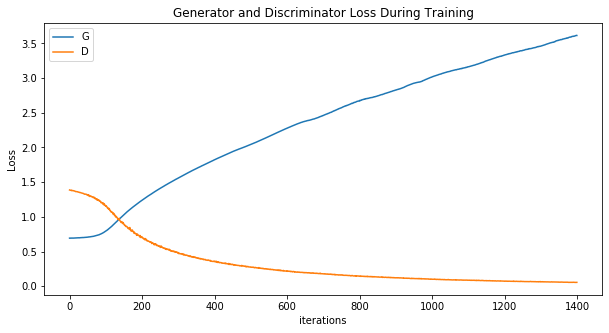

In [9]:
plot_train_loss()

# Animation

In [10]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

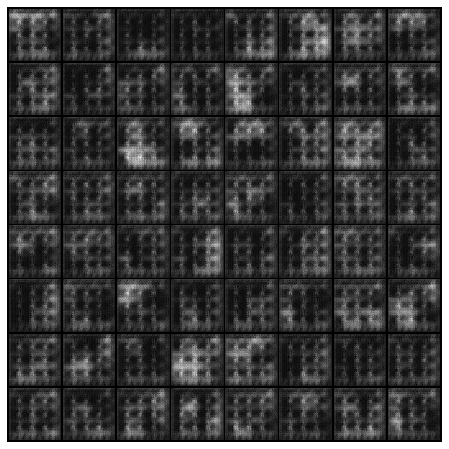

In [11]:
animate_gen_imgs()

# Anomaly Loss

In [12]:
latent_vector = torch.randn(1, latent_size, 1, 1, device = device, requires_grad=True)

def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    _, Test_Data_feature = D(Test_Data)
    _, G_Data_feature = D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

z_optimizer = torch.optim.Adam([latent_vector],lr=0.01,betas=(0.5, 0.999))


test_data_root = "../../../OhSeHyeon/source/dataset/test/test_CFRP"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))


# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# Train Latent Space Z

In [13]:
latent_space = []
auc=[]

def train_latent_space():
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data = G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step == 400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss > 500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [14]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 1344.0922  Sum_of_z : -9.7755
[200]	 Ano_loss : 1314.6450  Sum_of_z : -9.5294
[400]	 Ano_loss : 1312.0736  Sum_of_z : -1.7852
picture  2
[0]	 Ano_loss : 675.4438  Sum_of_z : -1.9153
[200]	 Ano_loss : 606.5317  Sum_of_z : -1.4720
[400]	 Ano_loss : 604.3134  Sum_of_z : 8.6728
picture  3
[0]	 Ano_loss : 539.2327  Sum_of_z : 8.7677
[200]	 Ano_loss : 511.9880  Sum_of_z : 11.4345
[400]	 Ano_loss : 510.1606  Sum_of_z : 7.5056
picture  4
[0]	 Ano_loss : 1085.5975  Sum_of_z : 7.5865
[200]	 Ano_loss : 1058.4808  Sum_of_z : 4.2954
[400]	 Ano_loss : 1057.0443  Sum_of_z : 9.7207
picture  5
[0]	 Ano_loss : 968.5623  Sum_of_z : 9.3373
[200]	 Ano_loss : 890.7723  Sum_of_z : -17.2398
[400]	 Ano_loss : 890.0692  Sum_of_z : -18.7596
picture  6
[0]	 Ano_loss : 1292.8136  Sum_of_z : -18.6420
[200]	 Ano_loss : 1266.3722  Sum_of_z : -1.3174
[400]	 Ano_loss : 1264.9897  Sum_of_z : 7.8288
picture  7
[0]	 Ano_loss : 1408.5281  Sum_of_z : 8.0629
[200]	 Ano_loss : 1337.8398  Sum_of_z : 

[200]	 Ano_loss : 789.6129  Sum_of_z : -2.0754
[400]	 Ano_loss : 786.0332  Sum_of_z : -5.1273
picture  56
[0]	 Ano_loss : 1658.4622  Sum_of_z : -5.0803
[200]	 Ano_loss : 1625.6283  Sum_of_z : -15.4249
[400]	 Ano_loss : 1624.2883  Sum_of_z : -12.5868
picture  57
[0]	 Ano_loss : 1988.2079  Sum_of_z : -12.6760
[200]	 Ano_loss : 1924.1230  Sum_of_z : -43.8747
[400]	 Ano_loss : 1915.0581  Sum_of_z : -33.5240
picture  58
[0]	 Ano_loss : 1937.1797  Sum_of_z : -33.5077
[200]	 Ano_loss : 1906.1791  Sum_of_z : -14.1445
[400]	 Ano_loss : 1903.9836  Sum_of_z : -1.9607
picture  59
[0]	 Ano_loss : 1993.4965  Sum_of_z : -1.9085
[200]	 Ano_loss : 1993.0227  Sum_of_z : 5.1103
[400]	 Ano_loss : 1992.8594  Sum_of_z : 7.9157
picture  60
[0]	 Ano_loss : 544.4690  Sum_of_z : 7.9043
[200]	 Ano_loss : 535.0044  Sum_of_z : 16.4801
[400]	 Ano_loss : 516.6295  Sum_of_z : 30.3806


---

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# Similar Z , Ano_Score and Segementation


In [16]:
diff_cnts = []
diff_points = []
anomaly_imgs = []


def compare_imgs(real_img, generated_img, i, reverse=False, threshold=50):
    global anomaly_img
    
    score = Anomaly_loss(real_img, generated_img)
    score = round(score.item(), 2)
    
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    negative = np.zeros_like(real_img)
    
    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    diff_img[diff_img <= threshold] = 0
    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)
    if auc[i] == 0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')

/home/piai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


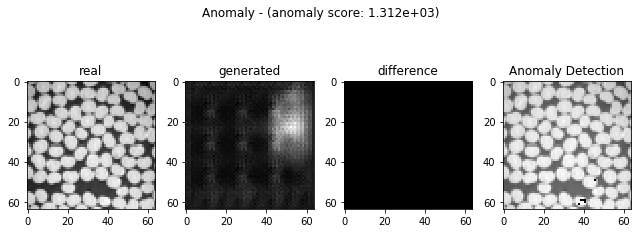

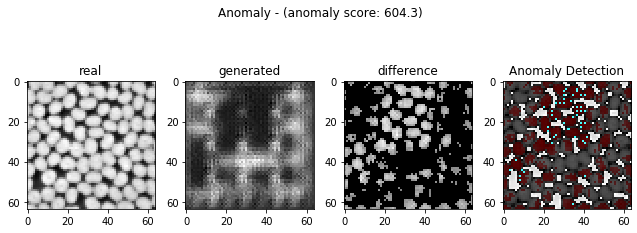

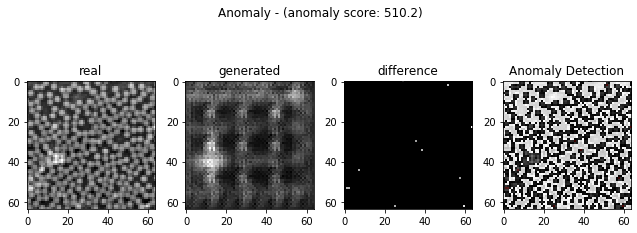

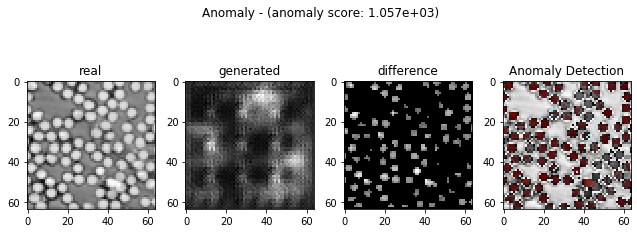

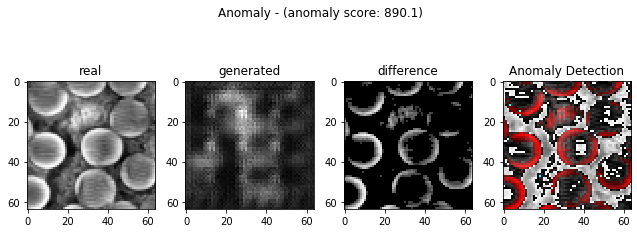

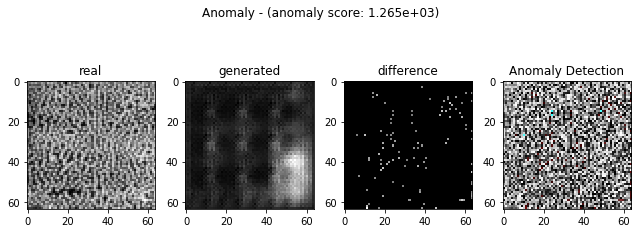

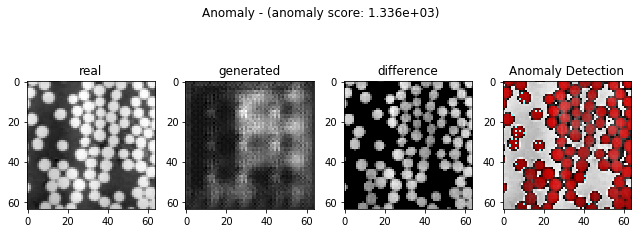

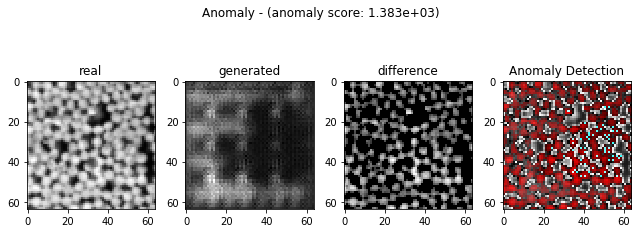

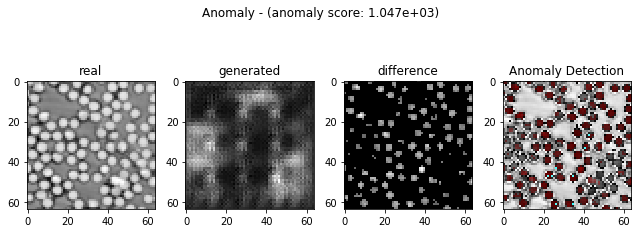

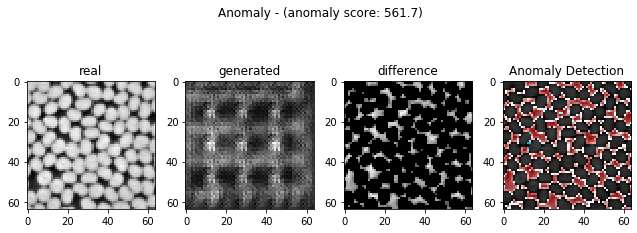

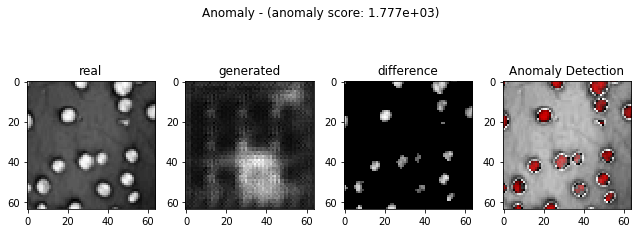

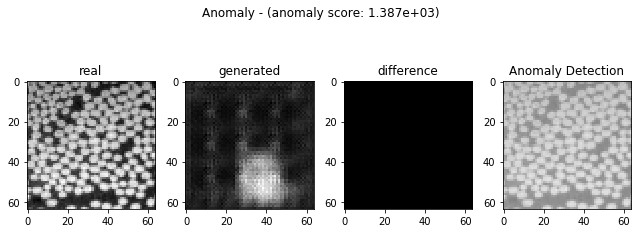

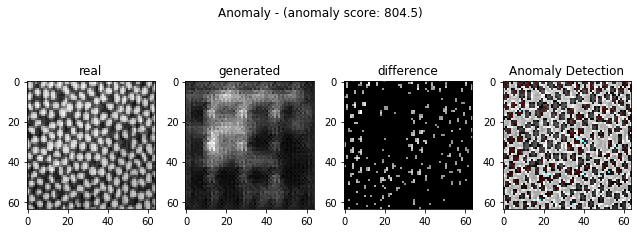

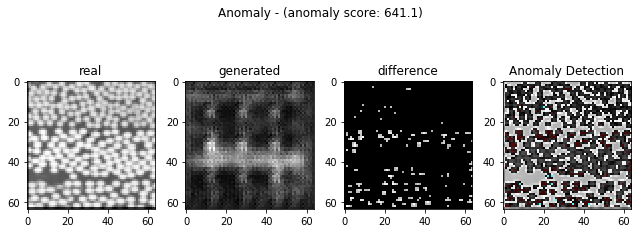

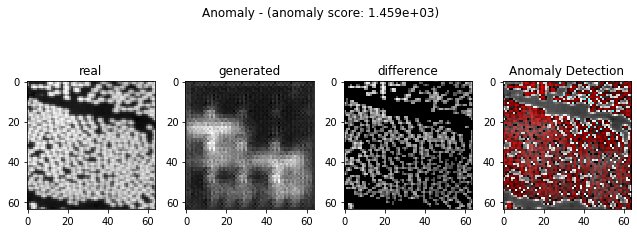

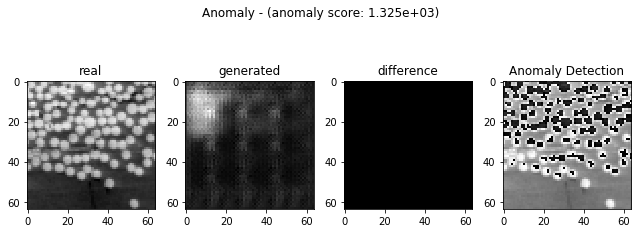

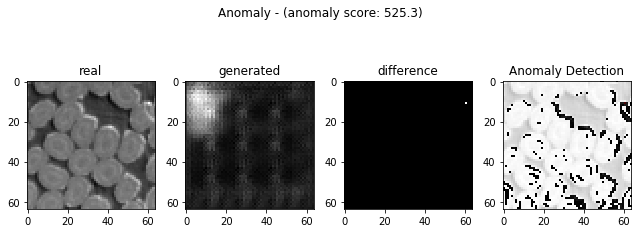

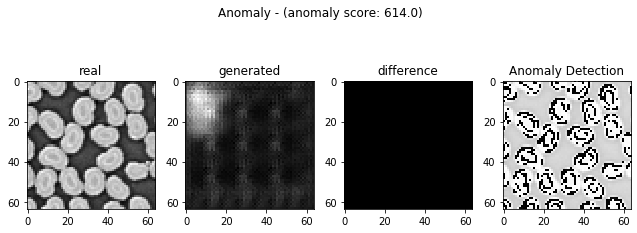

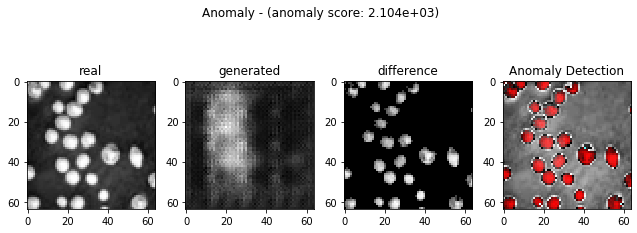

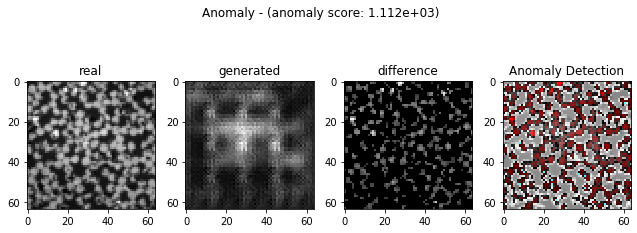

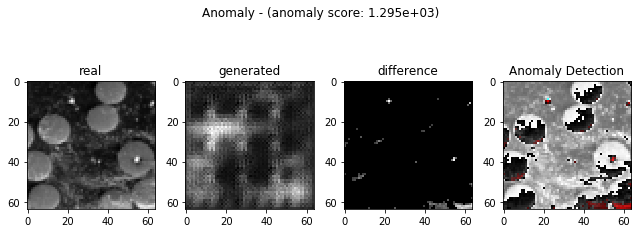

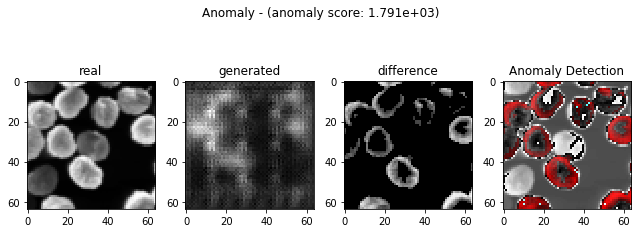

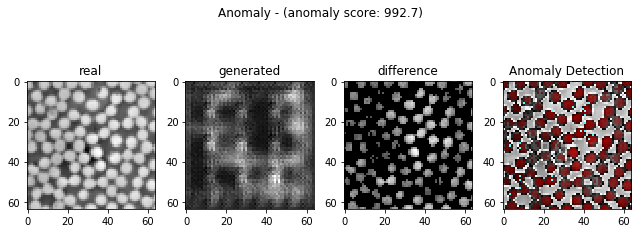

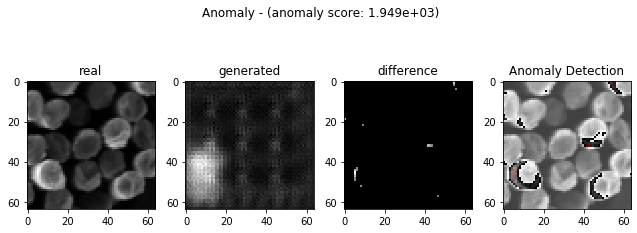

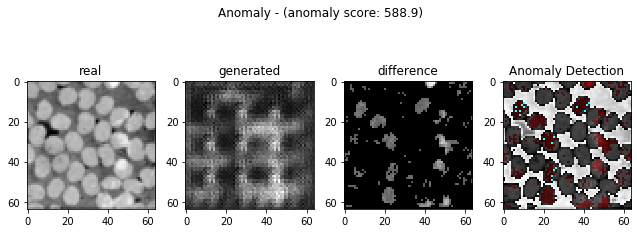

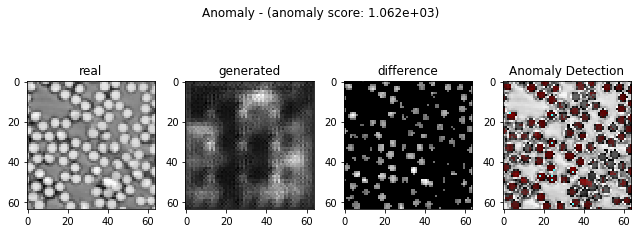

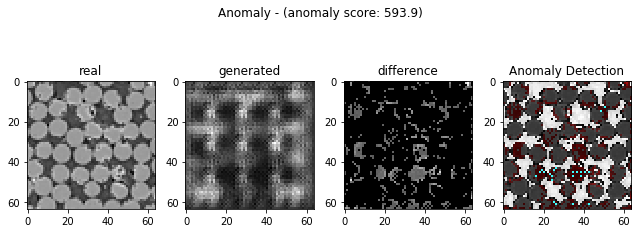

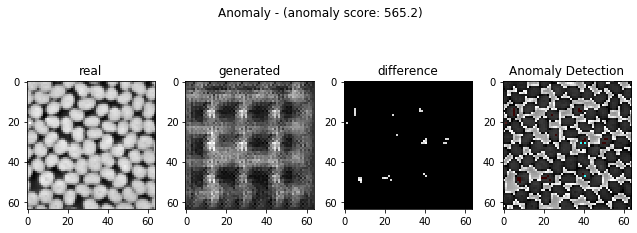

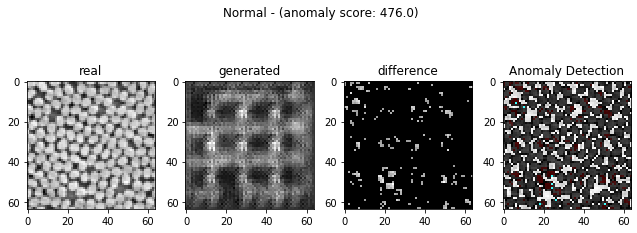

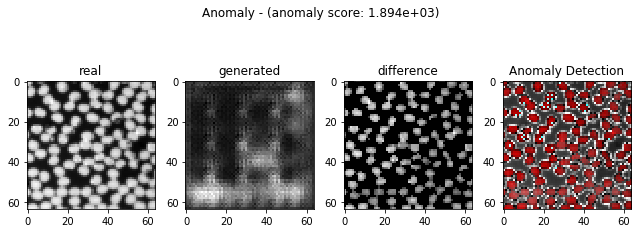

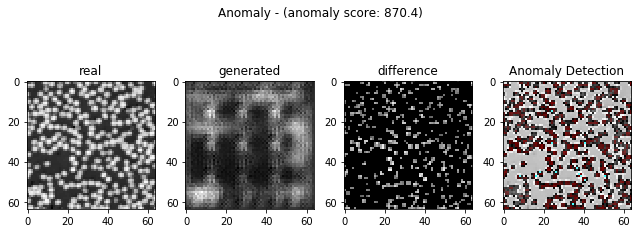

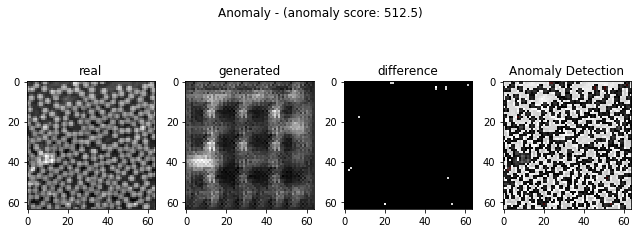

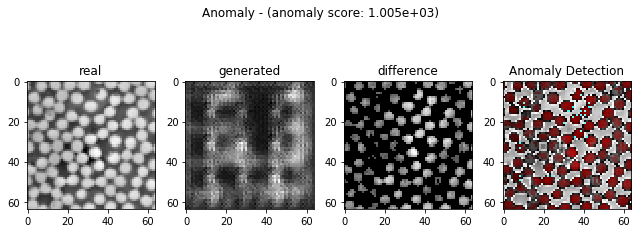

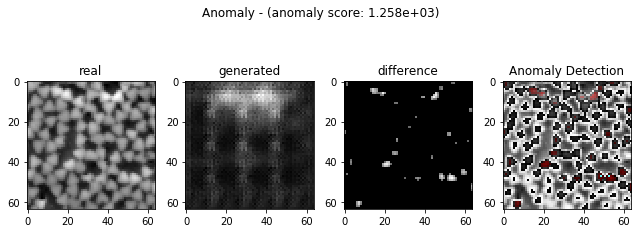

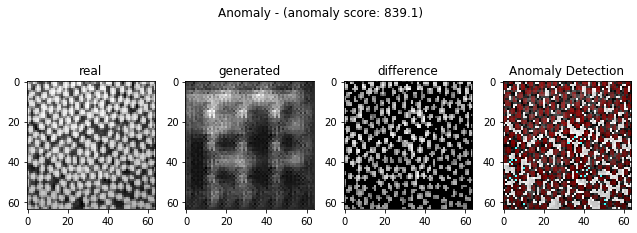

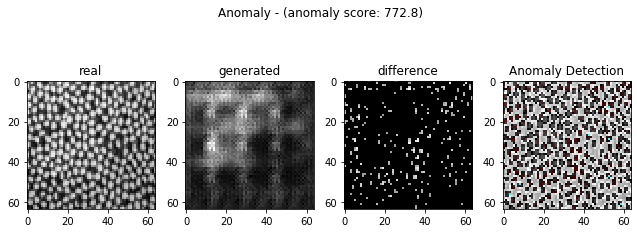

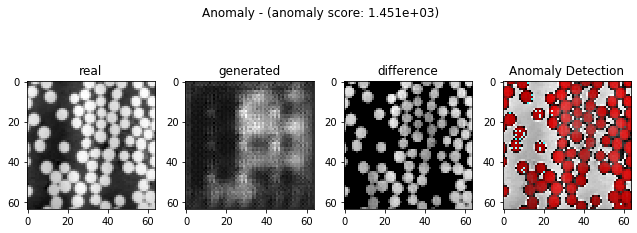

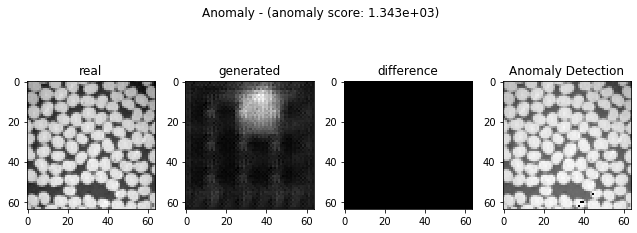

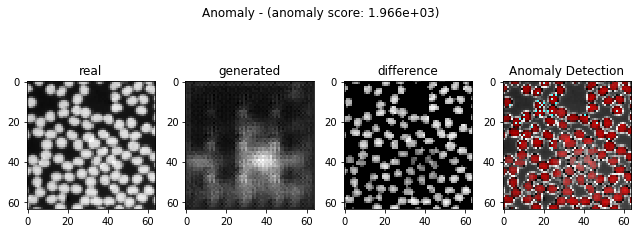

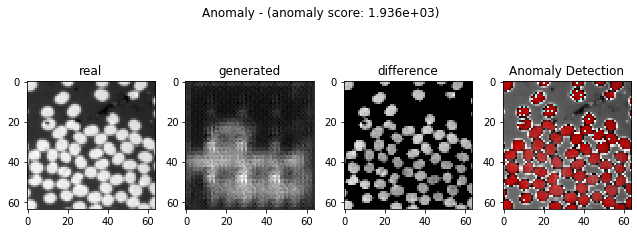

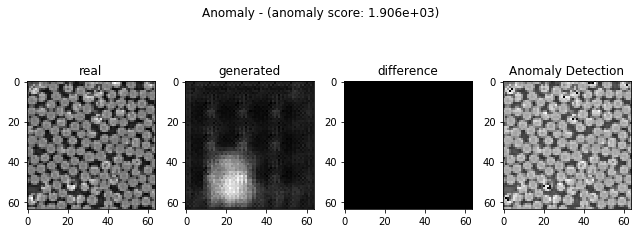

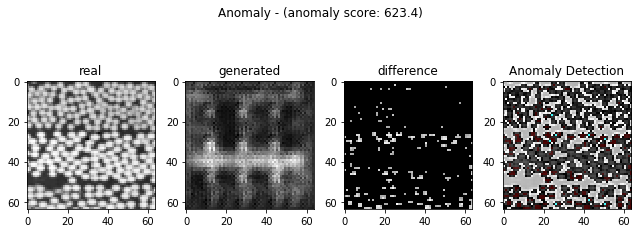

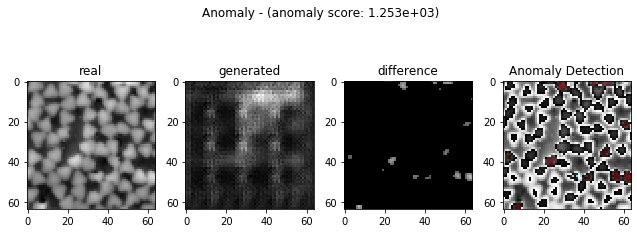

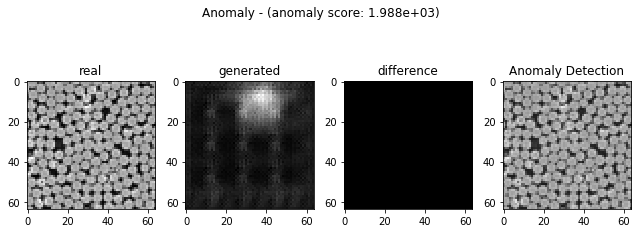

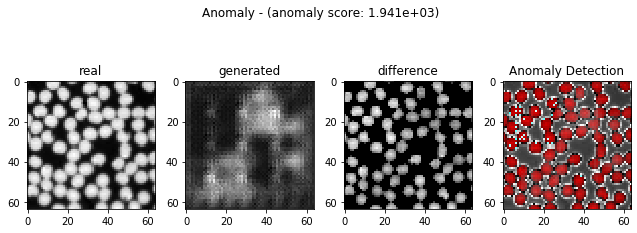

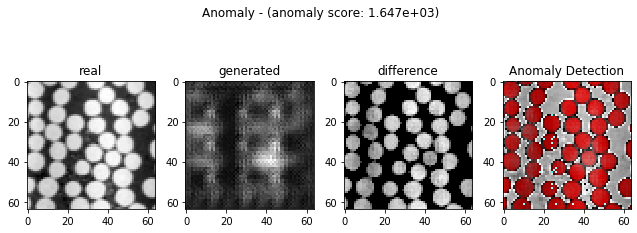

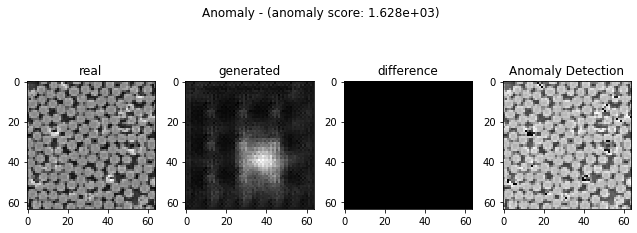

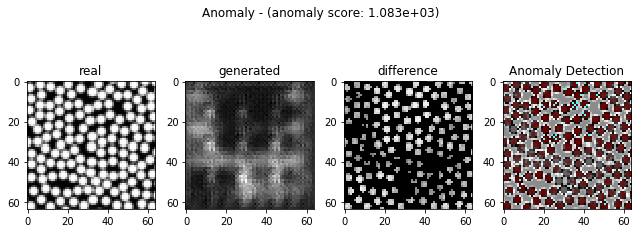

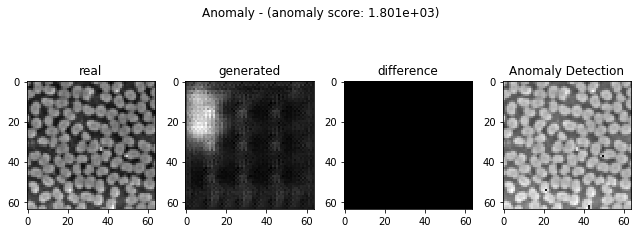

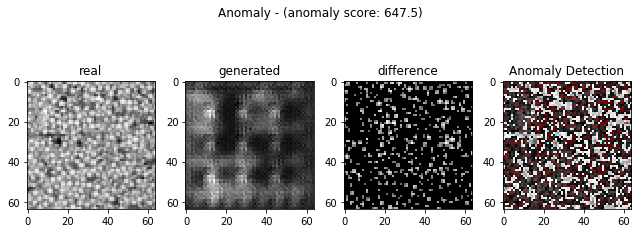

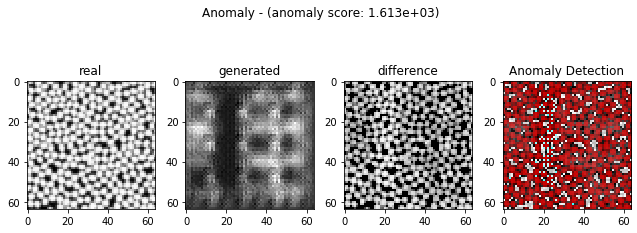

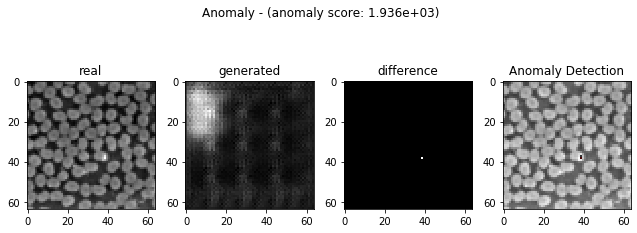

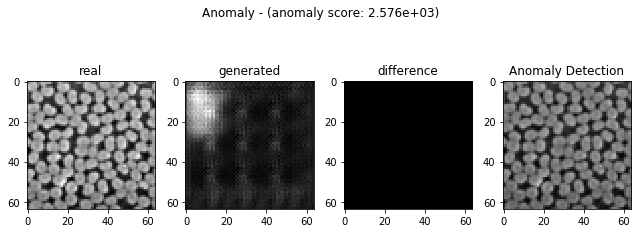

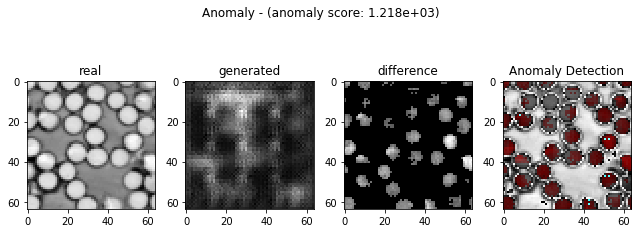

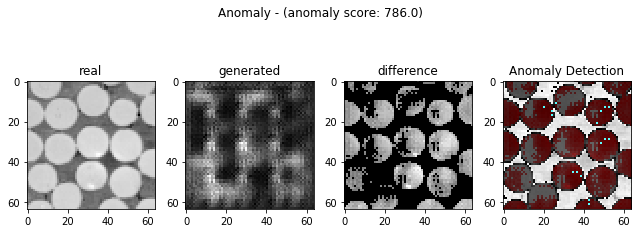

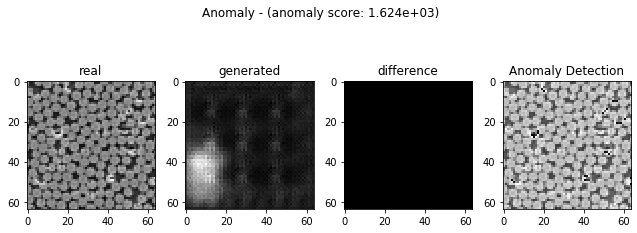

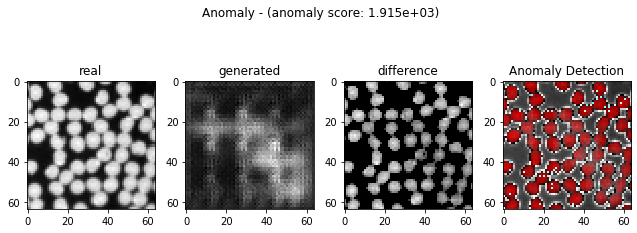

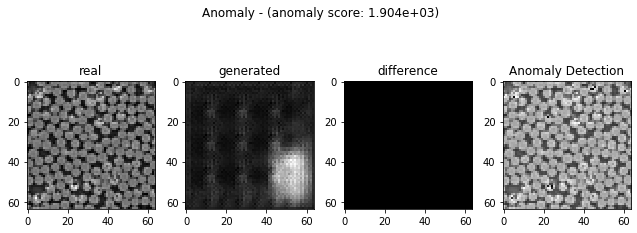

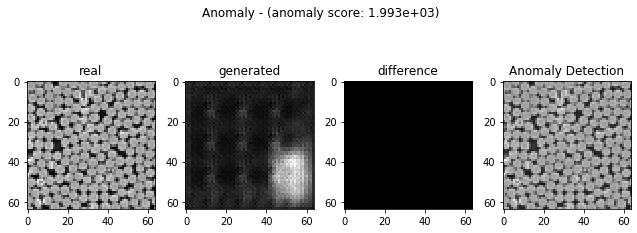

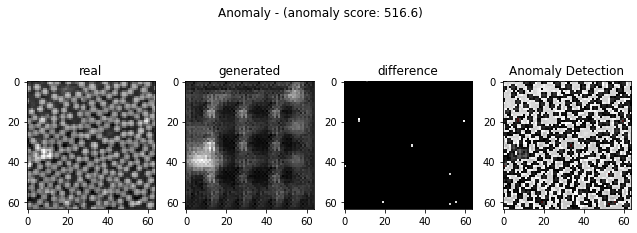

In [17]:
for i,data in enumerate(test_data_loader,0):
    test_img = data[0].to(device)

    #for i in range(len(latent_space)):
    update_z = latent_space[i]
    R_img = test_img
    G_img = G(update_z).to(device)
    
    if i in [9]:
        compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
    else:
        compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.00000000e+00 3.05664062e-01 2.68554688e-03 1.70410156e-01
 2.59765625e-01 2.44140625e-02 4.89013672e-01 4.97070312e-01
 1.69921875e-01 2.47070312e-01 7.83691406e-02 0.00000000e+00
 8.44726562e-02 5.66406250e-02 4.77783203e-01 0.00000000e+00
 2.44140625e-04 0.00000000e+00 1.68457031e-01 2.58789062e-01
 2.61230469e-02 2.15820312e-01 3.44726562e-01 4.63867188e-03
 1.36230469e-01 1.74316406e-01 1.66503906e-01 7.81250000e-03
 6.42089844e-02 3.74755859e-01 1.80175781e-01 3.17382812e-03
 3.55712891e-01 3.17382812e-02 4.28710938e-01 7.32421875e-02
 4.85351562e-01 0.00000000e+00 3.75976562e-01 3.85009766e-01
 0.00000000e+00 7.08007812e-02 2.73437500e-02 0.00000000e+00
 4.23583984e-01 5.34912109e-01 0.00000000e+00 2.94677734e-01
 0.00000000e+00 1.96289062e-01 7.24853516e-01 2.44140625e-04
 0.00000000e+00 2.15332031e-01 4.55322266e-01 0.00000000e+00
 4.33593750e-01 0.00000000e+00 0.00000000e+00 2.44140625e-03]


---

# 분산 추출

In [26]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)
        print(corr_coeffi)

In [27]:
cal_corr_coeffis()

print(corr_coeffis)

-inf
-0.0476140233271151
-0.2813461963402452
-0.1056812635516124
0.0347244246964886
-0.14407937015686412
0.009480522655788425
-0.02032546157660107
-0.10835596266216901
-0.058086169769379206
-0.2797103107717992
-inf
-0.11007619499026504
0.06500386954506418
0.04737159064144713
-inf


ValueError: x and y must have length at least 2.

---

# 모델 저장 및 읽기

In [21]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "G" : G.state_dict(),
        #"latent_space" : latent_space.state_dict(), # nn.model만 가지는 기능
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [22]:
save_pretrained()

In [23]:
pretrained_D = Discriminator().to(device)
pretrained_G = Generator().to(device)
#pretrained_latent_space = [] # 다시 학습해야 함

def load_pretrained():
    global pretrained_D
    global pretrained_G
    #global pretrained_latent_space
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_G.load_state_dict(pretrained["G"])
    #pretrained_latent_space.load_state_dict(pretrained["latent_space"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_G)
    #print("pretrained_latent_space :", pretrained_latent_space)

In [24]:
load_pretrained()

In [25]:
def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    
    _, Test_Data_feature = pretrained_D(Test_Data)
    _, G_Data_feature = pretrained_D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

In [26]:
# train latent_space

latent_space = []
auc = []

def train_latent_space():
    global latent_space
    global auc
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data   = pretrained_G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step==400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss>500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [27]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 1266.3403  Sum_of_z : -3.3242
[200]	 Ano_loss : 1264.7040  Sum_of_z : 0.9610
[400]	 Ano_loss : 1264.6361  Sum_of_z : 1.0947
picture  2
[0]	 Ano_loss : 1201.3168  Sum_of_z : 1.3532
[200]	 Ano_loss : 1199.7808  Sum_of_z : 11.9149
[400]	 Ano_loss : 1199.6984  Sum_of_z : 12.8498
picture  3
[0]	 Ano_loss : 1015.5364  Sum_of_z : 12.9203
[200]	 Ano_loss : 1013.7377  Sum_of_z : 6.7273
[400]	 Ano_loss : 1013.6226  Sum_of_z : -1.5176
picture  4
[0]	 Ano_loss : 524.4009  Sum_of_z : -1.5813
[200]	 Ano_loss : 523.0158  Sum_of_z : -6.6464
[400]	 Ano_loss : 522.9283  Sum_of_z : -4.0442
picture  5
[0]	 Ano_loss : 1090.5264  Sum_of_z : -4.1989
[200]	 Ano_loss : 1090.0314  Sum_of_z : -11.3059
[400]	 Ano_loss : 1090.0150  Sum_of_z : -12.8962
picture  6
[0]	 Ano_loss : 345.9109  Sum_of_z : -12.8769
[200]	 Ano_loss : 344.4709  Sum_of_z : 4.4213
[400]	 Ano_loss : 344.2828  Sum_of_z : 12.5208
picture  7
[0]	 Ano_loss : 671.7592  Sum_of_z : 12.4988
[200]	 Ano_loss : 670.0259  Sum_of

In [28]:
def test():
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)

        #for i in range(len(latent_space)):
        update_z = latent_space[i]
        R_img = test_img
        G_img = pretrained_G(update_z).to(device)

        if i in [9]:
            compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
        else:
            compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

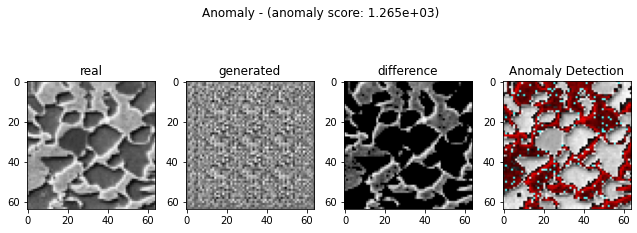

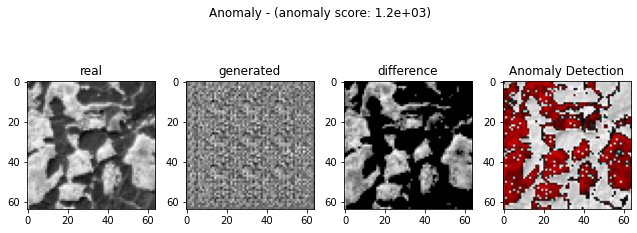

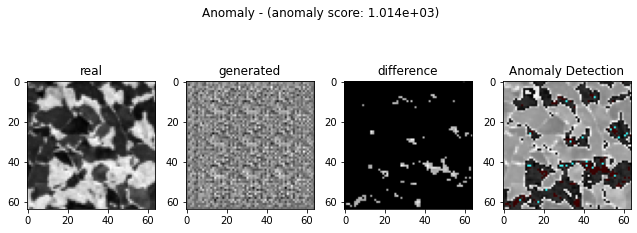

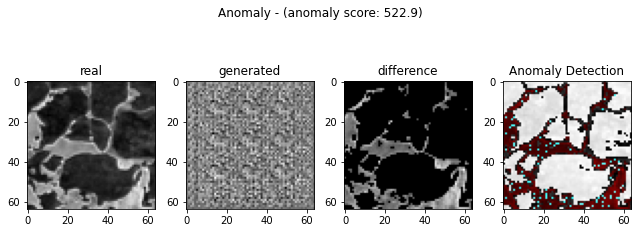

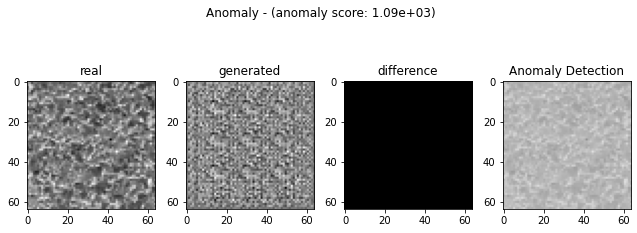

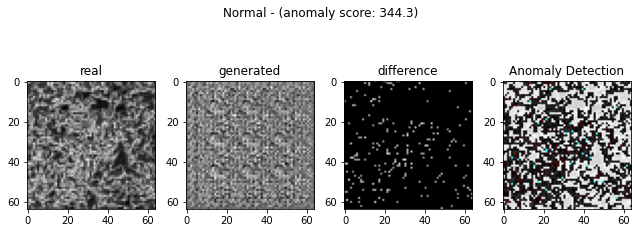

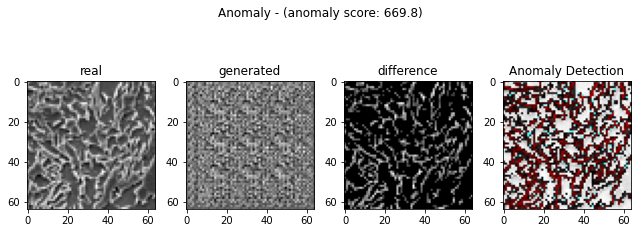

In [29]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [30]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.42578125 0.46264648 0.04516602 0.2355957  0.         0.04980469
 0.29760742]


In [31]:
cal_corr_coeffis()

print(corr_coeffis)

[0.03930323451955458, 0.09824271107967668, -0.28914111459826475, 0.19809595979534306, -inf, 0.04507935167666852, -0.08497257982755216]


---

# anomaly detection 이미지 추출

In [32]:
anomaly_imgs

[array([[[242, 242, 242],
         [246, 246, 246],
         [121,   0,   0],
         ...,
         [210, 210, 210],
         [176, 176, 176],
         [222, 222, 222]],
 
        [[248, 248, 248],
         [242, 242, 242],
         [ 87,   1,   1],
         ...,
         [238, 238, 238],
         [238, 238, 238],
         [190, 190, 190]],
 
        [[236, 236, 236],
         [230, 230, 230],
         [ 77,   3,   3],
         ...,
         [230, 230, 230],
         [232, 232, 232],
         [238, 238, 238]],
 
        ...,
 
        [[230, 230, 230],
         [248, 248, 248],
         [212, 212, 212],
         ...,
         [142, 142, 142],
         [ 85,  85,  85],
         [130, 130, 130]],
 
        [[228, 228, 228],
         [244, 244, 244],
         [230, 230, 230],
         ...,
         [105, 105, 105],
         [150, 150, 150],
         [252, 252, 252]],
 
        [[218, 218, 218],
         [228, 228, 228],
         [246, 246, 246],
         ...,
         [182, 182, 182],
  

# 이미지 저장 함수

In [33]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [34]:
save_imgs("./anomaly_imgs", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [35]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[1.88621094 2.04952393 0.20008545 1.04368896 0.         0.22063477
 1.31840088]
